<a href="https://colab.research.google.com/github/stevecrawshaw/hackathon/blob/main/Copy_of_hackathon_eda_sc_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install relevant modules

In colab this needs to be done at the start of every session. The install is not persistent for more than a few hours it seems



In [1]:
!pip install --upgrade geopandas pyshp shapely descartes
!pip install --upgrade pandas_profiling
!pip install --upgrade geoplot
!pip install google-colab-shell # this gives us a bash shell 
!pip install --upgrade imageio
# !pip install av

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gp
from pandas_profiling import ProfileReport # only works on UBUNTU!
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import imageio
from google_colab_shell import getshell
from google.colab import drive # connects to a G drive for access to data
# from av import *
%matplotlib inline

### Health Data
This is a DF of health establishments detailing the facilities available and some location data. It is difficult to relate this dataset with the COVID data as it is somewhat sparse, quite old and there is no obvious link to the covid data in terms of facilities or outcomes.

In [75]:
# drive.mount('/content/drive')

In [3]:
health_df_raw = pd.read_csv('drive/MyDrive/work/health.csv', index_col = 'facility_name')

In [4]:
# health_df_raw

#### We can explore the health facility data with EDA tool `Pandas Profiling`

In [5]:
health_profile = ProfileReport(health_df_raw, title = "Health Facility EDA Report") # some sort of pandas incompatability error (works on ubuntu)

In [6]:
# health_profile

## COVID cases:
Dates, locations and patient details for COVID cases

The COVID-19 data are interesting for analysis as there are spatial and temporal dimensions. We can investigate the change in covid cases over time and space and hypothesize about the reasons for the patterns.

The `province/state` column looks useful for joining onto geographic data sets.
It's not clear what `source` means. There's a lot of missing data, including age, which is significant for our later analyses.

In [7]:
covid_df_raw = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/line_lists/line-list-nigeria.csv',
                          index_col = ['case_id'])

In [11]:
covid_df_raw.describe

<bound method NDFrame.describe of          origin_case_id        date  age  gender   city province/state  \
case_id                                                                  
1                   NaN   2/27/2020   44    Male   Ogun           Ogun   
2                   NaN  03/09/2020  NaN     NaN   Ogun           Ogun   
3                   NaN   3/16/2020   30  Female  Lagos          Lagos   
4                   NaN   3/16/2020   58    Male  Lagos          Lagos   
5                   NaN   3/16/2020   38  Female    NaN          Ekiti   
...                 ...         ...  ...     ...    ...            ...   
6397                NaN  05/19/2020  NaN     NaN    NaN         Bauchi   
6398                NaN  05/19/2020  NaN     NaN    NaN          Gombe   
6399                NaN  05/19/2020  NaN     NaN    NaN          Gombe   
6400                NaN  05/19/2020  NaN     NaN    NaN          Enugu   
6401                NaN  05/19/2020  NaN     NaN    NaN        Bayelsa   

   

In [12]:
covid = covid_df_raw.copy()

covid['date'] = pd.to_datetime(covid_df_raw['date'])

In [13]:
covid.set_index('date', inplace=True)

In [14]:
covid_profile = ProfileReport(covid, title = 'Covid Data Report')

In [15]:
# covid_profile

## plot the rise in COVID-19 cases over the early months of the pandemic
Data provided for March 2020 to mid May 2020

### In common with the UK and other countries, cases of COVID-19 in Nigeria did not start to be registered until mid - March 2020 and then grew steeply

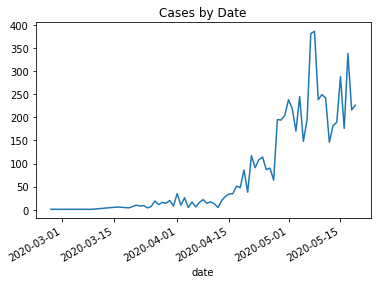

In [16]:
ax = covid.groupby('date').count().country.plot();
# ax.rcParams["figure.figsize"] = (5,5)
ax.set_title('Cases by Date');

In [17]:

# read the CSV file
df = pd.read_csv("https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/line_lists/line-list-nigeria.csv")

#making a cumulative date graph
dates = df[['case_id', 'date']]

# Convert the dates column to a datetime object
dates['date'] = pd.to_datetime(dates['date'])

# Group by date
day = dates.groupby('date').count()

<ipython-input-17-7e398c598e27>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates['date'] = pd.to_datetime(dates['date'])


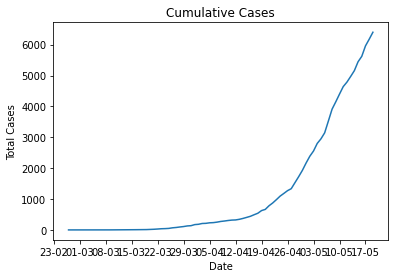

In [18]:
# Create a cumulative graph
cumulative_graph = plt.plot(day.cumsum())
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('Cumulative Cases')

# Set the x-axis tick locations
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
# plt.figure(figsize=(15,15))
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

## How do demographic parameters influence COVID-19 cases and morbidity?

| Country | Average Lifespan | Total Population | Pop Over 50 | Pop Over 60 | Pop Over 70 | Pop Over 80
:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:
<font color=green>Nigeria</font>|<font color=green>52.9 years</font>| <font color=green>204,909,220</font>   | <font color=green>20,721,577</font> | <font color=green>10,082,137</font> | <font color=green>3,803,483</font> | <font color=green>752,680</font>
<font color=green>%</font> | <font color=green>-</font> | <font color=green>-</font> | <font color=green>10%</font> | <font color=green>5%</font> | <font color=green>2%</font> | <font color=green>0.4%</font>
<font color=blue>(UK)</font>| <font color=blue>(80.9 years) </font> | <font color=blue>(68,791,308) </font> | <font color=blue>(35%)</font> | <font color=blue>(23%)</font> | <font color=blue>(12%)</font> | <font color=blue>(5%)</font>

 

### Case Counts
- Nigeria's dataset holds 6,401 covid cases for the country.
- Cases span across the first two months of covid.
- Lagos had the highest case count with 2,756 cases (185.2 cases per million, pop 14,879,754).
- Lagos is Known to be the Largest city in Nigeria and a major African financial center.
- Abuja (2nd highest case count) and Kano (3rd highest) are also states with high population counts.

## [Coronavirus in Africa: Five reasons why Covid-19 has been less deadly than elsewhere](https://gdc.unicef.org/resource/coronavirus-africa-five-reasons-why-covid-19-has-been-less-deadly-elsewhere)

* Quick Action
* Public Support
* Young population - and few old-age homes. Older people, and people of all ages with pre-existing medical conditions (such as diabetes, high blood pressure, heart disease, lung disease, or cancer) appear to [develop serious illness more often than others.](https://www.who.int/news-room/questions-and-answers/item/coronavirus-disease-covid-19-risks-and-safety-for-older-people)
Compared to people under 40 years old, the chances of dying from COVID-19 are 70 times higher for those aged over 80 and 50 times higher among those aged 70-79 (COVID-19: review of disparities in risks and outcomes).
* Favourable climate
* Good community health systems 

### Age distribution in Nigeria
Nigeria is a young country!
Lots of experience in tackling infection disease (Ebola, HIV)

### Population data
Admin level 1 data (State) was used as level 0 was for the whole country and Level 2 was too granular


In [19]:
# read data from files
nga_adm0_2020_df_raw = pd.read_csv('https://data.humdata.org/dataset/a7c3de5e-ff27-4746-99cd-05f2ad9b1066/resource/4710c51c-813b-481f-bb4e-ffb593e6f126/download/nga_admpop_adm0_2020.csv')
nga_adm1_2020_df_raw = pd.read_csv('https://data.humdata.org/dataset/a7c3de5e-ff27-4746-99cd-05f2ad9b1066/resource/d9fc551a-b5e4-4bed-9d0d-b047b6961817/download/nga_admpop_adm1_2020.csv')
# nga_adm2_2020_df_raw = pd.read_csv('https://data.humdata.org/dataset/a7c3de5e-ff27-4746-99cd-05f2ad9b1066/resource/562e7757-0683-4d61-87bd-a7c94af2ee38/download/nga_admpop_adm2_2020.csv')


In [20]:
admcols = nga_adm0_2020_df_raw.filter(regex='T_')
# nga_adm2_2020 = nga_adm2_2020_df_raw.drop(columns = unnamed)
admcols = admcols.drop(columns = ['T_TL'])
# admcols.T.plot(kind = 'bar');

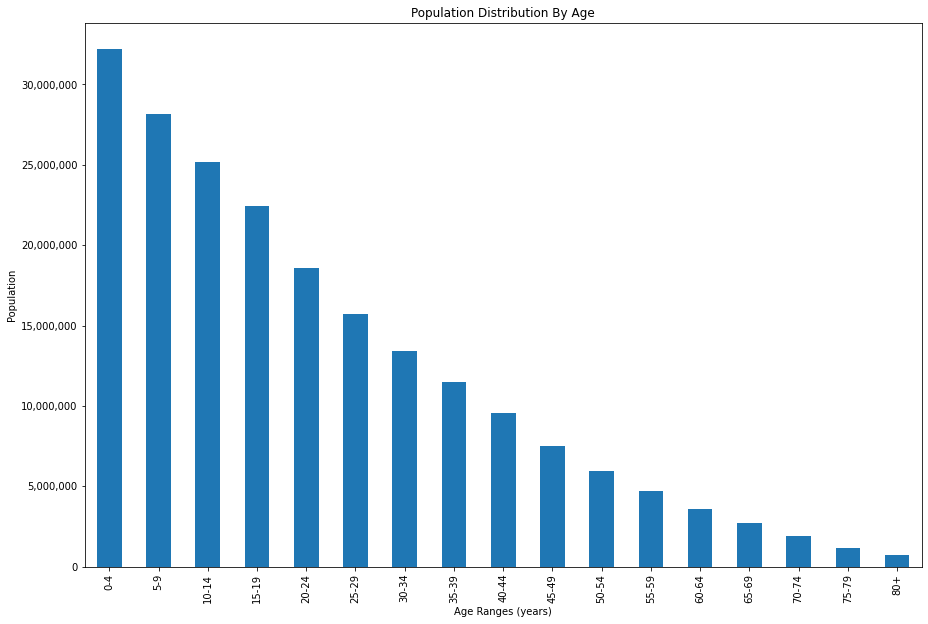

In [21]:
admcols.rename(
    columns={"T_00_04": "0-4", "T_05_09": "5-9", "T_10_14": "10-14", "T_15_19": "15-19", "T_20_24": "20-24", "T_25_29": "25-29",
             "T_30_34": "30-34", "T_35_39": "35-39", "T_40_44": "40-44", "T_45_49": "45-49", "T_50_54": "50-54", "T_55_59": "55-59",
             "T_60_64": "60-64", "T_65_69": "65-69", "T_70_74": "70-74", "T_75_79": "75-79", "T_80Plus": "80+"},
    inplace=True,
)

admcols.T.plot(kind = 'bar', legend = None, figsize= (15,10));

plt.title('Population Distribution By Age')
plt.xlabel('Age Ranges (years)')
plt.ylabel('Population')

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

plt.show()

#### ADMIN LEVEL 1

In [22]:
#check the names of the state - Level 1 Admin boundaries
nga_adm1_2020_df_raw.ADM1_NAME.unique()

array(['ABIA', 'ADAMAWA', 'AKWA IBOM', 'ANAMBRA', 'BAUCHI', 'BAYELSA',
       'BENUE', 'BORNO', 'CROSS RIVER', 'DELTA', 'EBONYI', 'EDO', 'EKITI',
       'ENUGU', 'FEDERAL CAPITAL TERRITORY', 'GOMBE', 'IMO', 'JIGAWA',
       'KADUNA', 'KANO', 'KATSINA', 'KEBBI', 'KOGI', 'KWARA', 'LAGOS',
       'NASARAWA', 'NIGER', 'OGUN', 'ONDO', 'OSUN', 'OYO', 'PLATEAU',
       'RIVERS', 'SOKOTO', 'TARABA', 'YOBE', 'ZAMFARA'], dtype=object)

In [41]:
# Nigeria administrative level 1 (state) 2016 projected population statistics
nga_adm1_2020_df_raw.head()

,Country,ADM0_PCODE,State,ADM1_PCODE,F_TL,M_TL,Total,F_00_04,F_05_09,F_10_14,...,T_35_39,T_40_44,T_45_49,T_50_54,T_55_59,T_60_64,T_65_69,T_70_74,T_75_79,T_80Plus
0,NIGERIA,NG,ABIA,NG001,1937239,1941738,3878977,210483,215867,248705,...,222947,194133,175852,134694,126513,84071,78976,48921,35513,19470
1,NIGERIA,NG,ADAMAWA,NG002,2168252,2228347,4396599,372760,320576,273011,...,225579,188995,143381,116482,94120,72897,58057,46415,27654,17161
2,NIGERIA,NG,AKWA IBOM,NG003,2789212,2876552,5665764,326260,342223,353787,...,340402,288166,256081,190410,160830,125151,98786,53539,32155,15171
3,NIGERIA,NG,ANAMBRA,NG004,2932876,3003908,5936784,319470,334304,379733,...,350214,302323,270660,201279,185087,122166,110187,64398,48022,23577
4,NIGERIA,NG,BAUCHI,NG005,3272516,3417618,6690134,639299,509011,402259,...,322124,276823,193548,172873,109191,101830,60952,58276,31020,23856


In [24]:
nga_adm1_2020_df_raw.rename(columns = {'ADM1_NAME':'State', 'T_TL':'Total'}, inplace = True)

In [25]:
nga_adm1_2020_df_raw.head()

,ADM0_NAME,ADM0_PCODE,State,ADM1_PCODE,F_TL,M_TL,Total,F_00_04,F_05_09,F_10_14,...,T_35_39,T_40_44,T_45_49,T_50_54,T_55_59,T_60_64,T_65_69,T_70_74,T_75_79,T_80Plus
0,NIGERIA,NG,ABIA,NG001,1937239,1941738,3878977,210483,215867,248705,...,222947,194133,175852,134694,126513,84071,78976,48921,35513,19470
1,NIGERIA,NG,ADAMAWA,NG002,2168252,2228347,4396599,372760,320576,273011,...,225579,188995,143381,116482,94120,72897,58057,46415,27654,17161
2,NIGERIA,NG,AKWA IBOM,NG003,2789212,2876552,5665764,326260,342223,353787,...,340402,288166,256081,190410,160830,125151,98786,53539,32155,15171
3,NIGERIA,NG,ANAMBRA,NG004,2932876,3003908,5936784,319470,334304,379733,...,350214,302323,270660,201279,185087,122166,110187,64398,48022,23577
4,NIGERIA,NG,BAUCHI,NG005,3272516,3417618,6690134,639299,509011,402259,...,322124,276823,193548,172873,109191,101830,60952,58276,31020,23856


In [26]:
state_pop_totals = nga_adm1_2020_df_raw[['State', 'T_50_54', 'T_55_59', 'T_60_64', 'T_65_69', 'T_70_74', 'T_75_79', 'T_80Plus']]

state_pop_totals = state_pop_totals.set_index('State')
state_pop_totals['Total_50_plus'] = state_pop_totals.sum(axis=1)
state_pop_totals = state_pop_totals.reset_index()
state_pop_totals = state_pop_totals[['State', 'Total_50_plus']]
state_pop_totals.head(3)

,State,Total_50_plus
0,ABIA,528158
1,ADAMAWA,432786
2,AKWA IBOM,676042


In [27]:
states_total = nga_adm1_2020_df_raw[['State', 'Total']]
states_total.head()

,State,Total
0,ABIA,3878977
1,ADAMAWA,4396599
2,AKWA IBOM,5665764
3,ANAMBRA,5936784
4,BAUCHI,6690134


In [28]:
state_pop_elderly = pd.merge(state_pop_totals, states_total, how='left', on='State')
state_pop_elderly['%_50_plus'] = state_pop_elderly['Total_50_plus'] / state_pop_elderly['Total']
state_pop_elderly = state_pop_elderly.sort_values(by='%_50_plus', ascending=False)
state_pop_elderly['rank'] = state_pop_elderly['%_50_plus'].rank(ascending=False)
state_pop_elderly = state_pop_elderly.set_index('State')

### Analysis shows that cities have relatively high populations of young people, e.g. Lagos and Abuja are in the lower 50 percentile of states for percent of over 50's 

In [29]:
state_pop_elderly
# Lagos rank 20/37, Kano 31/37, Abuja 37/37.

,Total_50_plus,Total,%_50_plus,rank
State,,,,
ENUGU,623369,4415727,0.141170,1.0
ABIA,528158,3878977,0.136159,2.0
IMO,739363,5547527,0.133278,3.0
ANAMBRA,754716,5936784,0.127125,4.0
EDO,548071,4393070,0.124758,5.0
OSUN,602402,4828740,0.124753,6.0
DELTA,719207,5827726,0.123411,7.0
OYO,1034106,8470586,0.122082,8.0
EKITI,420137,3510952,0.119665,9.0


#### ADMIN LEVEL 2

In [30]:
# Nigeria administrative level 2 (local government area) 2016 projected population statistics
# nga_adm2_2020_df_raw.head(3)

In [31]:
# remove extraneous columns
# NOT RUN
# unnamed = nga_adm2_2020_df_raw.filter(regex='Unnamed').columns
# admcols = nga_adm2_2020_df_raw.filter(regex='ADM').columns
# nga_adm2_2020 = nga_adm2_2020_df_raw.drop(columns = unnamed)

In [32]:
# melt to make long
# NOT RUN
# nga_adm2_2020_long = pd.melt(nga_adm2_2020,
#         var_name = 'sex_age_cat',
#         value_name = 'population',
#         id_vars = admcols) 

In [33]:
# nga_adm2_2020_long

## Investigating the spatial spread of COVID -19 in Nigeria
Plot a thematic map of total covid cases by joining the covid data to the boundary data in the geodatabase. Including total population gives us a per - capita COVID hospital admissions dataset which can be used to plot the map, and mitigates the dominating effect of large population centres.

In [34]:
case_count_by_state = covid_df_raw.groupby("province/state").country.count()

In [35]:
df_case_count_by_state = pd.DataFrame(case_count_by_state)

In [36]:
df_case_count_by_state = df_case_count_by_state.reset_index()

df_case_count_by_state['province/state'] = df_case_count_by_state['province/state'].str.upper()  
df_case_count_by_state.rename(columns = {'province/state': 'State', 'country': 'case_count'}, inplace = True)

In [37]:
# df_case_count_by_state

In [42]:
#cleaning and renaming
nga_adm1_2020_df_raw.rename(columns={'ADM0_NAME':'Country', 'ADM1_NAME':'State', 'Total':'Total_Population'}, inplace=True)

In [40]:
nga_adm1_2020_df_raw


,Country,ADM0_PCODE,State,ADM1_PCODE,F_TL,M_TL,Total,F_00_04,F_05_09,F_10_14,...,T_35_39,T_40_44,T_45_49,T_50_54,T_55_59,T_60_64,T_65_69,T_70_74,T_75_79,T_80Plus
0,NIGERIA,NG,ABIA,NG001,1937239,1941738,3878977,210483,215867,248705,...,222947,194133,175852,134694,126513,84071,78976,48921,35513,19470
1,NIGERIA,NG,ADAMAWA,NG002,2168252,2228347,4396599,372760,320576,273011,...,225579,188995,143381,116482,94120,72897,58057,46415,27654,17161
2,NIGERIA,NG,AKWA IBOM,NG003,2789212,2876552,5665764,326260,342223,353787,...,340402,288166,256081,190410,160830,125151,98786,53539,32155,15171
3,NIGERIA,NG,ANAMBRA,NG004,2932876,3003908,5936784,319470,334304,379733,...,350214,302323,270660,201279,185087,122166,110187,64398,48022,23577
4,NIGERIA,NG,BAUCHI,NG005,3272516,3417618,6690134,639299,509011,402259,...,322124,276823,193548,172873,109191,101830,60952,58276,31020,23856
5,NIGERIA,NG,BAYELSA,NG006,1236961,1300813,2537774,150454,157800,157102,...,153376,128944,110058,82540,66162,50687,36981,23625,15061,8625
6,NIGERIA,NG,BENUE,NG007,2880342,2934586,5814928,514586,431588,371409,...,281738,239486,182443,149576,108491,101214,67470,52832,33773,24258
7,NIGERIA,NG,BORNO,NG008,3154724,3440268,6594992,596867,492977,369247,...,323088,299736,193375,186002,109394,117696,60404,63438,28207,23607
8,NIGERIA,NG,CROSS RIVER,NG009,1942578,2015687,3958265,243102,247026,247067,...,232842,197977,169135,129210,96751,78950,59830,35842,23514,12724
9,NIGERIA,NG,DELTA,NG010,2899761,2927965,5827726,352059,347139,365330,...,341617,282303,255786,187501,178717,111598,103232,62783,48926,26450


In [43]:
state_pop_total = nga_adm1_2020_df_raw[['State', 'Total_Population']]

state_pop_total.head()

,State,Total_Population
0,ABIA,3878977
1,ADAMAWA,4396599
2,AKWA IBOM,5665764
3,ANAMBRA,5936784
4,BAUCHI,6690134


In [44]:
state_pop_total['State'] = state_pop_total['State'].replace(['FEDERAL CAPITAL TERRITORY'], ['ABUJA'])

<ipython-input-44-f94c8359eea2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_pop_total['State'] = state_pop_total['State'].replace(['FEDERAL CAPITAL TERRITORY'], ['ABUJA'])


### Boundary geodata from Geo database

Geo data for Nigeria from ESRI Geo database  
Read the GDB into a geopandas df   
Looks like polygon boundaries for admin layers  
Each layer in the dB represents a different administrative polygon boundary

In [45]:
# Read data
# country_geodata = gpd.read_file('nga_admbnda_osgof_eha_itos.gdb', layer = 0) # country
admin_1_geodata = gpd.read_file('drive/MyDrive/work/nga_admbnda_osgof_eha_itos.gdb', layer = 1) # ADM1
# admin_2_geodata = gpd.read_file('nga_admbnda_osgof_eha_itos.gdb', layer = 2) # ADM2


In [46]:
admin_1_geodata.head(2)

,admin1Name_en,admin1Pcode,admin1RefName,admin1AltName1_en,admin1AltName2_en,admin0Name_en,admin0Pcode,date,validOn,validTo,Shape_Length,Shape_Area,geometry
0,Abia,NG001,Abia,None,None,Nigeria,NG,2016-11-29 00:00:00+00:00,2016-12-15 00:00:00+00:00,NaT,4.695135,0.396543,"MULTIPOLYGON (((7.38681 6.03667, 7.38729 6.036..."
1,Adamawa,NG002,Adamawa,None,None,Nigeria,NG,2016-11-29 00:00:00+00:00,2016-12-15 00:00:00+00:00,NaT,11.525443,3.113007,"MULTIPOLYGON (((13.62129 10.94823, 13.62592 10..."


### Plot of State (Admin level 1) Boundaries

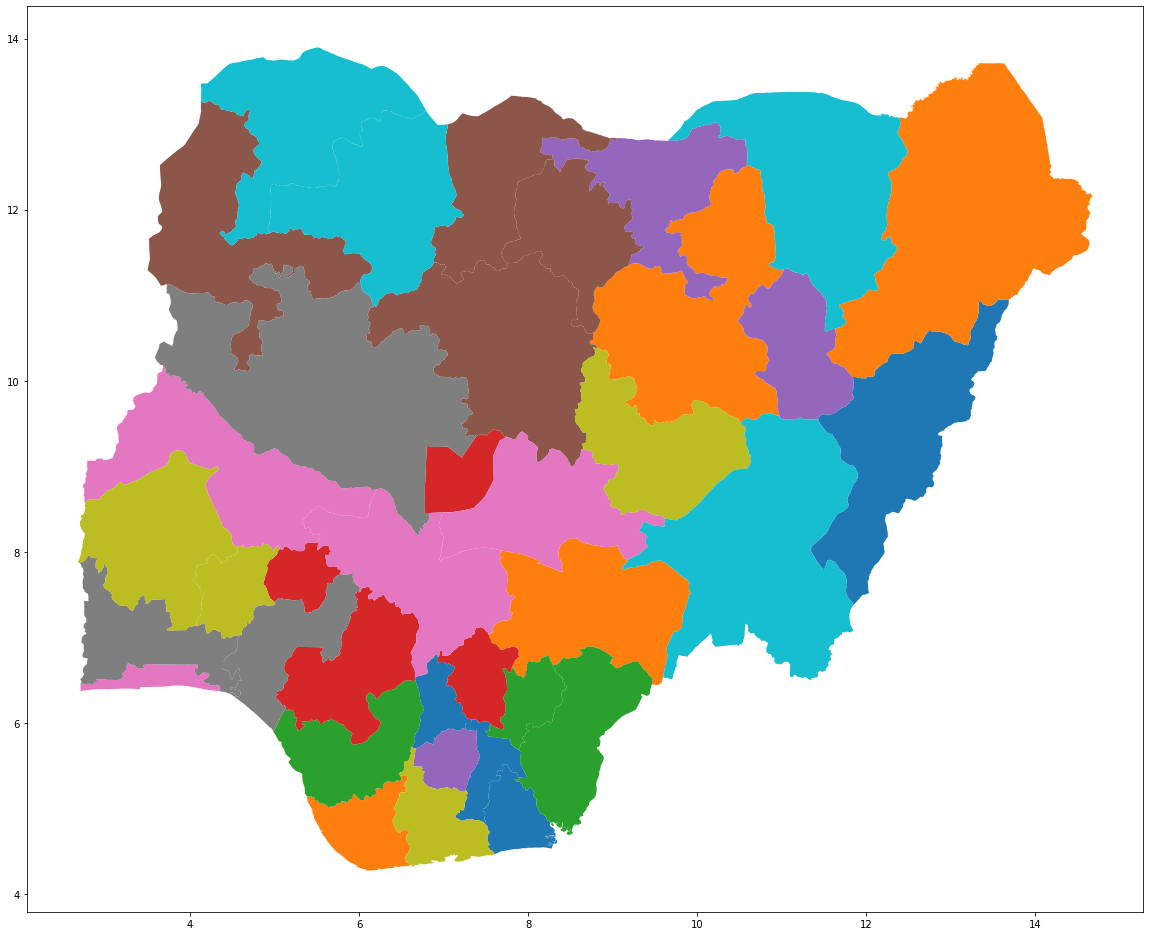

In [47]:
admin_1_geodata.plot(column = 'admin1Pcode', legend = False);

In [48]:
# creating copies of the datasets to work with
cases = df_case_count_by_state.copy()
boundary = admin_1_geodata.copy()

In [49]:
# renaming the "city" column in the cases dataset to merge
boundary = boundary.rename({
    "admin1Name_en" : "State"}, 
    axis = 'columns')

In [50]:
# get all the states in the right format for joining
boundary['State'] = boundary['State'].str.upper()
# Abuja = Federal capital; territory - this is populous
boundary['State'] = boundary['State'].replace(['FEDERAL CAPITAL TERRITORY'], ['ABUJA'])

# boundary

In [51]:
df_case_count_by_state.head()

,State,case_count
0,ABIA,5
1,ABUJA,427
2,ADAMAWA,26
3,AKWA IBOM,18
4,ANAMBRA,5


In [52]:

# merging datasets a left join to allow all boundary data to be populated with any case counts data
cases_count_by_area = pd.merge(
    boundary, 
    df_case_count_by_state,
    how='left', 
    on='State')
cases_count_by_area.shape


(37, 14)

In [53]:
# subsets columns
cases_count_by_area = cases_count_by_area[[
    "State",
    "geometry",
    "case_count"]] # Check count data column name is correct

cases_count_by_area.head()

,State,geometry,case_count
0,ABIA,"MULTIPOLYGON (((7.38681 6.03667, 7.38729 6.036...",5.0
1,ADAMAWA,"MULTIPOLYGON (((13.62129 10.94823, 13.62592 10...",26.0
2,AKWA IBOM,"MULTIPOLYGON (((8.34482 4.61140, 8.34496 4.609...",18.0
3,ANAMBRA,"MULTIPOLYGON (((6.93254 6.71090, 6.93167 6.698...",5.0
4,BAUCHI,"MULTIPOLYGON (((10.75125 12.46148, 10.75615 12...",224.0


In [54]:
all_joined = pd.merge(cases_count_by_area,
                      state_pop_total,
                      how = 'left',
                      on = 'State')



In [55]:
all_joined['hosp_cases_per_million'] = (all_joined['case_count']  / all_joined['Total_Population']) * 1000000
# all_joined = all_joined.fillna(0)

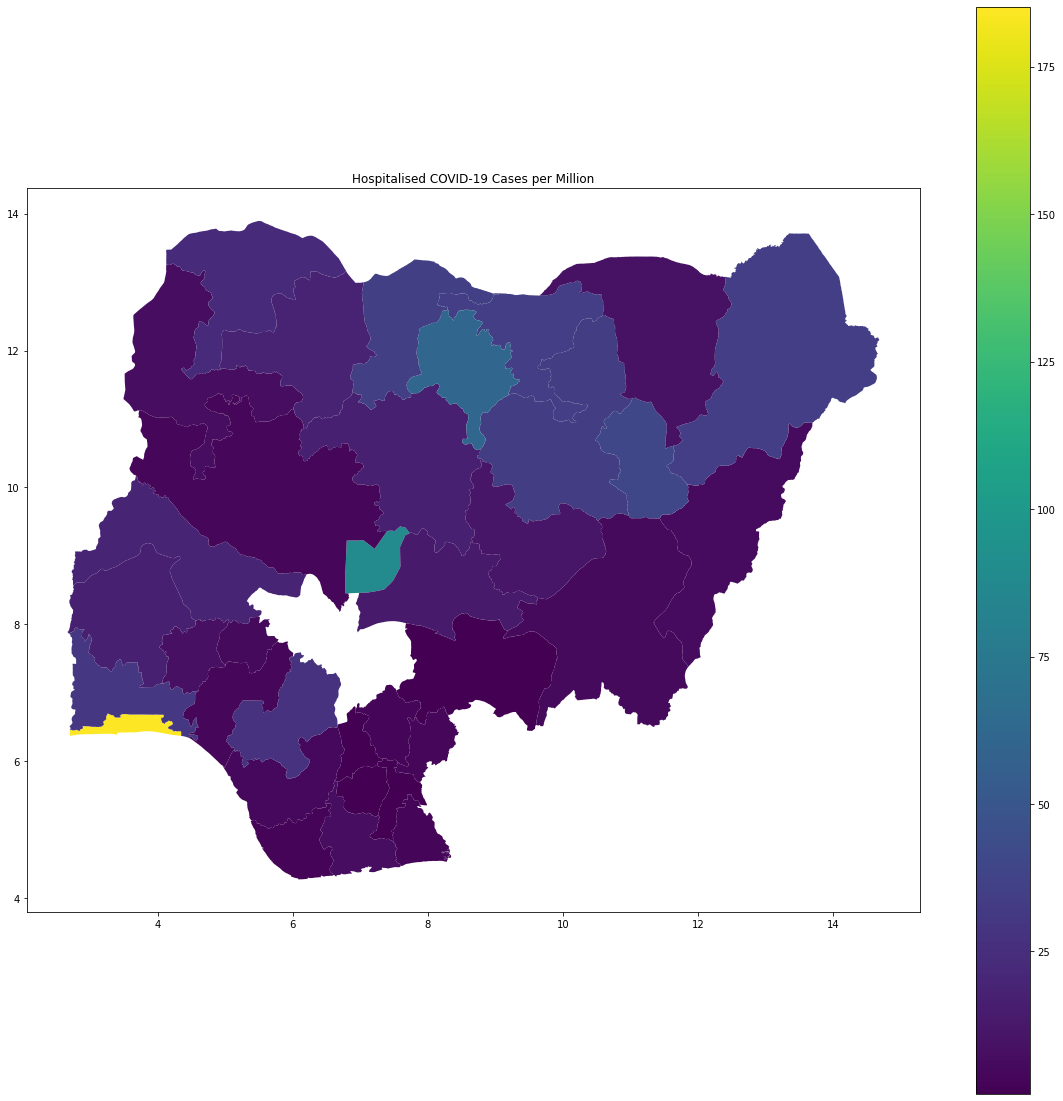

In [56]:
ax = all_joined.plot('hosp_cases_per_million', legend = True);
ax.set_title('Hospitalised COVID-19 Cases per Million');

## An animated map may show the spread of COVID in early 2020
The COVID-19 data is sparse. There are low rates of admissions when considering the total population. This may be related to a range of social factors as identified in the UNICEF analysis above.

## [Animated Maps with Pandas](https://towardsdatascience.com/how-to-make-a-gif-map-using-python-geopandas-and-matplotlib-cd8827cefbc8)

Code was adapted from this tutorial.
* Data were reshaped to give weekly sums of cases by state.
* Then loop over the columns to create a thematic map for each week, saving the map as a consecutively numbered .png file.
*Finally the .png files were assembled into an animated .gif with the imageio library

In [57]:
covid = covid.reset_index()
covid['week_commencing'] = covid['date'].map(lambda x: x.to_period("W").start_time)

In [58]:
df_weekly_case_count_by_state = covid.groupby(['week_commencing', 'province/state'])['country'].count()

df_weekly_case_count_by_state = pd.DataFrame(df_weekly_case_count_by_state)

df_weekly_case_count_by_state.head()



country
week_commencing province/state         
2020-02-24      Ogun                  1
2020-03-09      Ogun                  1
2020-03-16      Abuja                 4
                Ekiti                 1
                Lagos                22

In [59]:
df_weekly_case_count_by_state_2 = df_weekly_case_count_by_state.reset_index()

df_weekly_case_count_by_state_2.rename(columns={'country':'case_count', 'province/state':'State'}, inplace=True)

df_weekly_case_count_by_state_2 = df_weekly_case_count_by_state_2.sort_values(by=['week_commencing'])

df_weekly_case_count_by_state_2['State'] = df_weekly_case_count_by_state_2['State'].str.upper()

df_weekly_case_count_by_state_2.head()

,week_commencing,State,case_count
0,2020-02-24,OGUN,1
1,2020-03-09,OGUN,1
2,2020-03-16,ABUJA,4
3,2020-03-16,EKITI,1
4,2020-03-16,LAGOS,22


In [60]:
df_weekly_case_count_by_state_2['week_commencing'] = df_weekly_case_count_by_state_2['week_commencing'].astype('str')
pivot = df_weekly_case_count_by_state_2.pivot_table(index='State', columns='week_commencing', values=['case_count'])
pivot = pivot.fillna(0)
pivot.columns = pivot.columns.get_level_values(1)

pivot.head()

week_commencing,2020-02-24,2020-03-09,2020-03-16,2020-03-23,2020-03-30,2020-04-06,2020-04-13,2020-04-20,2020-04-27,2020-05-04,2020-05-11,2020-05-18
State,,,,,,,,,,,,
ABIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0
ABUJA,0.0,0.0,4.0,17.0,26.0,9.0,32.0,53.0,137.0,78.0,62.0,9.0
ADAMAWA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,11.0,4.0,5.0
AKWA IBOM,0.0,0.0,0.0,0.0,5.0,0.0,4.0,2.0,4.0,1.0,2.0,0.0
ANAMBRA,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0


In [61]:
boundary_to_join = boundary.set_index('State')

map_source_df = pd.merge(boundary_to_join,
                         pivot,
                         left_index=True,
                         right_index=True,
                         how = 'left')


In [62]:
map_source_df  = gpd.GeoDataFrame(map_source_df)

In [63]:
# save all the maps in the charts folder
output_path = 'drive/MyDrive/work/png'
# list of weeks_year (which are the column names at the moment)
list_of_weeks = map_source_df.filter(regex='2020-').columns

In [64]:
# set the min and max range for the choropleth map
vmin, vmax = 0, 500

In [ ]:
# start the for loop to create one map per week
for week in list_of_weeks:

    # our dataframe needs to be a geopandas df with the relevant columns being weekly total cases by state
    # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
  fig = map_source_df.plot(column=week,
                           cmap='RdYlGn_r',
                           figsize=(15,15),
                           linewidth=0.8,
                           edgecolor='0.8',
                           vmin=vmin,
                           vmax=vmax,
                           legend=True,
                           norm=plt.Normalize(vmin=vmin,
                                              vmax=vmax))
    
    # remove axis of chart
  fig.axis('off')
    
    # add a title
  fig.set_title('Weekly Covid Admissions', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    # position the annotation to the bottom left
  fig.annotate(week,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path
  filepath = os.path.join(output_path, week +'_covid_nigeria.png')
  chart = fig.get_figure()
  chart.savefig(filepath, dpi=300);

In [66]:
# list the files and construct full path for each one
arr = os.listdir(output_path)
filenames = [output_path + "/" + f for f in arr] # list comprehension to create vector of filenames

In [67]:
filenames

['drive/MyDrive/work/png/2020-02-24_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-03-09_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-03-16_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-03-23_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-03-30_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-04-06_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-04-13_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-04-20_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-04-27_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-05-04_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-05-11_covid_nigeria.png',
 'drive/MyDrive/work/png/2020-05-18_covid_nigeria.png']

In [79]:
# imageio.imread(filenames[0])

## Generate an animated GIF
Each of the png files created for the weekly state COVID data are combined into an animated GIF which shows the progression of the disease across the country.

The imageio module is used for this. A 3 second duration is implemented between frames to aid comprehension.

In [69]:
images = []
outfile =  "drive/MyDrive/work/covid_nigeria.gif"
for filename in filenames:
  images.append(imageio.imread(filename))
imageio.mimsave(outfile, images, duration = 3)

<ipython-input-69-494b8a90edf4>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [70]:
# outfile

str